<a href="https://colab.research.google.com/github/sudeep93/CE888/blob/main/lab4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
jester_data = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv",header=None)
jester_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [ ]:
len(jester_data)

24983

### Dropping column'0' 
As it denotes number of jokes that user have rated so far

In [ ]:
jester_data_copy = jester_data.drop(columns=0)
jester_data_copy.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [ ]:
jester_data_copy = jester_data_copy.replace(99.00,np.NaN)

In [ ]:
jester_data_copy.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


### Best and Worst rated jokes 

In [ ]:
a = jester_data_copy.mean(axis=0)

In [ ]:
best_joke_ids = a.idxmax()
worst_joke_ids =a.idxmin()

In [ ]:
print(best_joke_ids)
print(worst_joke_ids)


50
58


In [ ]:
jester_data_copy.iloc[1121,37]

7.28

In [ ]:
orig_arrays[1121][37]

7.28

### Create rated arrays

In [ ]:
orig_arrays = jester_data_copy.values

In [ ]:
orig_arrays

array([[-7.82,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 2.43,  2.67, -3.98, ...,   nan,   nan,   nan]])

### Creating Validation set 

In [ ]:
def getValidationArray(orig, percentage=0.1):
  new_data = orig.copy()
  rated = np.where(~np.isnan(orig))
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [ ]:
validation_arr, idx = getValidationArray(orig_arrays, 0.1)

In [ ]:
pd.DataFrame(validation_arr).shape

(24983, 100)

In [ ]:
orig_arrays[idx[0][0],idx[1][0]]

8.45

In [ ]:
validation_arr[idx[0][0], idx[1][0]]

99.0

### Latent Factor Model Building

In [ ]:
n_latent_factors = 2

user_ratings = jester_data_copy.values
# Initialise as random values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [ ]:
latent_user_preferences.shape

(24983, 2)

In [ ]:
latent_item_features.shape

(100, 2)

In [ ]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating) and rating < 99:
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

In [ ]:
num_iter = 100
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations

Iteration 0/100:	MSE=26.125066
Iteration 10/100:	MSE=23.052368
Iteration 20/100:	MSE=21.215156
Iteration 30/100:	MSE=19.392197
Iteration 40/100:	MSE=17.567674
Iteration 50/100:	MSE=17.240887
Iteration 60/100:	MSE=17.163942
Iteration 70/100:	MSE=17.140416
Iteration 80/100:	MSE=17.132916
Iteration 90/100:	MSE=17.130687


In [ ]:
hist

[26.125066025936572,
 23.052368063796123,
 21.2151560078601,
 19.39219650269136,
 17.56767400843619,
 17.240886532275315,
 17.163941708595168,
 17.14041575182598,
 17.132915736480097,
 17.130687275883965]

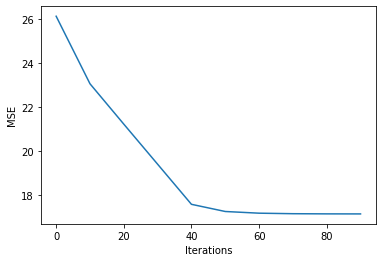

In [ ]:
plt.figure()
plt.plot(np.arange(0, num_iter, 10), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [ ]:
orig_arrays.shape

(24983, 100)

In [ ]:
validation_arr.shape

(24983, 100)

In [ ]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

In [ ]:
orig_arrays

array([[-7.82,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 2.43,  2.67, -3.98, ...,   nan,   nan,   nan]])

In [ ]:
validation_arr

array([[-7.82,  8.79, -9.66, ...,   nan,   nan,   nan],
       [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [ 2.43,  2.67, -3.98, ...,   nan,   nan,   nan]])

In [ ]:
# Calculate the performance of the algorithm on the validation dataset.

validation_error = []
for user in range(len(orig_arrays)):
  for rating in range(len(orig_arrays[user])):
    if(not np.isnan(orig_arrays[user][rating]) and orig_arrays[user][rating]!=validation_arr[user][rating] ):
      predict = predict_rating(user,rating)
      validation_error.append(orig_arrays[user][rating] - predict)
      print("Expected: " + str(orig_arrays[user][rating]) + "\tActual: " + str(predict))
print("Validation MSE is ,",(np.array(validation_error) ** 2).mean())

Streaming output truncated to the last 5000 lines.
Expected: 7.72	Actual: 6.460312349462021
Expected: 6.12	Actual: 4.92514434219567
Expected: 1.84	Actual: 2.2902095958593414
Expected: 1.89	Actual: 4.240546777779225
Expected: 3.16	Actual: 2.6293981984842176
Expected: -2.23	Actual: 0.26850440953815174
Expected: 8.06	Actual: 1.6955429697834365
Expected: 6.99	Actual: 5.432080480253039
Expected: 5.78	Actual: 4.777192950403102
Expected: 0.73	Actual: 4.0604373203580995
Expected: 8.54	Actual: -1.1410500993413255
Expected: 0.92	Actual: 0.20494962817779858
Expected: 3.74	Actual: 0.4186321880525088
Expected: -3.54	Actual: -8.17803824414108
Expected: 9.17	Actual: 3.366958351170095
Expected: 0.78	Actual: -0.744517711298505
Expected: 1.55	Actual: -0.7928087879158128
Expected: -7.43	Actual: -0.9850059117409955
Expected: 6.41	Actual: 1.6729886893322492
Expected: 2.91	Actual: 0.1633952422519746
Expected: 0.19	Actual: -1.4143271202416206
Expected: -7.28	Actual: 1.2639216942535587
Expected: 3.54	Actual: 

In [ ]:
# Predict Test Dataset
predictions =[]
for user in range(len(orig_arrays)):
  score=[]
  for rating in range(len(orig_arrays[user])):
    predict = predict_rating(user,rating)
    score.append(predict)
  predictions.append(score)


In [ ]:
orig_arrays[22903][21]

8.45

In [ ]:
validation_arr[22903][21]

99.0

In [ ]:
predictions[22903][21]

5.526818738833253

In [ ]:
values = [zip(user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = jester_data_copy.columns

In [ ]:
comparison_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, -3.904642603091457)","(8.79, -4.159406228000555)","(-9.66, -5.629917174807977)","(-8.16, -9.542316617972087)","(-7.52, -2.6600045508686385)","(-8.5, -1.776415602202744)","(-9.85, -4.883207558145652)","(4.17, -4.298431252083727)","(-8.98, -8.846744754255122)","(-4.76, -3.721698655577192)","(-8.5, -1.5907518999535257)","(-6.75, -1.7269882208040948)","(-7.18, -6.4767190856561045)","(8.45, -1.5601608286801298)","(-7.18, -6.5344628206630215)","(-7.52, -9.973463530674941)","(-7.43, -4.435578413886016)","(-9.81, -5.275730820573219)","(-9.85, -3.8066204603878266)","(-9.85, -6.111549123338332)","(-9.37, 0.4338447636044851)","(1.5, -4.293670390831344)","(-4.37, -6.083544116557993)","(-9.81, -10.565207474963676)","(-8.5, -4.630964418419471)","(1.12, -1.5611847340086737)","(7.82, 3.425891466691193)","(2.86, -1.6792792152183962)","(9.13, 3.4992273392389137)","(-7.43, -7.929932553245322)","(2.14, 1.118605162642865)","(-4.08, 3.2346177167797947)","(-9.08, -9.42863862823304)","(7.82, -2.674885104334636)","(5.05, 2.854870688150945)","(4.95, 3.6722608085199075)","(-9.17, -9.12092214268841)","(-8.4, -3.4573455477436963)","(-8.4, -2.493095195897774)","(-8.4, -3.656111603190874)",...,"(8.59, 1.2045239514578152)","(3.59, 2.1042024866286027)","(-6.84, -5.405981776741841)","(-9.03, -8.316234785473474)","(2.82, 1.3520504757961367)","(-1.36, 1.5238151856017625)","(-9.08, -8.799142629648708)","(8.3, 1.7345619539867183)","(5.68, 1.766979406369684)","(-4.81, -4.655079265827226)","(nan, -6.821643697510436)","(nan, 1.146507483571205)","(nan, -3.4015653109825554)","(nan, -9.227589447649358)","(nan, -6.067870786087661)","(nan, 0.5239733646042417)","(nan, -4.254089051028512)","(-9.42, -2.2975991807935627)","(nan, -5.415818876215878)","(nan, -2.733633157713565)","(nan, -1.3561264063505563)","(-7.72, -4.6770511143593225)","(nan, -0.38462724146151284)","(nan, -4.855872416762207)","(nan, -4.195043598718193)","(nan, -6.280652601772606)","(nan, -1.1663656991398414)","(nan, -1.2958232045160623)","(nan, 3.136809008718352)","(nan, -5.356418796715073)","(2.82, -1.5382521293331521)","(nan, -3.246257074252428)","(nan, 0.19088094297506872)","(nan, -4.777835486691204)","(nan, -3.9762390053197416)","(nan, -2.9234366821515865)","(-5.63, -2.2179971429594283)","(nan, -2.4648277354869106)","(nan, -6.226524452435253)","(nan, -2.5955207173659645)"
1,"(4.08, 2.9801877661748786)","(-0.29, 3.141146471407182)","(6.36, 3.781893861580622)","(4.37, 5.263438960619751)","(-2.38, 2.202817642331458)","(-9.66, 2.517907571703209)","(-0.73, 2.956212121141557)","(-5.34, 2.318192889918854)","(8.88, 5.071330689728183)","(9.22, 2.98979634123752)","(6.75, 2.3845198180710447)","(8.64, 2.5571058168338414)","(4.42, 3.1378458116353354)","(7.43, 2.47744987579581)","(4.56, 3.010931561565383)","(-0.97, 4.303655494550345)","(4.66, 2.4470634616322684)","(-0.68, 2.9405654134891073)","(3.3, 2.715374712931209)","(-1.21, 3.57669038350648)","(0.87, 1.6165494075107976)","(8.64, 3.480320524877777)","(8.35, 4.007554928285149)","(9.17, 5.512843041525972)","(0.05, 3.5318610959251404)","(7.57, 2.421355254951413)","(4.71, 0.23573731740878545)","(0.87, 2.3896541363057238)","(-0.39, 0.11804344235258304)","(6.99, 4.865843502117145)","(6.5, 1.247988777648382)","(-0.92, 0.3245974421275535)","(7.14, 5.2097266538997715)","(9.03, 2.760848847967499)","(-1.8, 0.5210071446101125)","(0.73, 0.05062852842459349)","(7.09, 4.848424798415997)","(3.4, 3.0617707126042966)","(-0.87, 2.7828452569989555)","(7.91, 3.2107562438486084)",...,"(-6.7, 1.3047331739084649)","(-3.35, 0.8839594388116854)","(-9.03, 3.7865793565740336)","(4.47, 4.714739080132121)","(4.08, 1.150486260054879)","(-3.83, 1.0728344593336914)","(8.74, 4.949609123159619)","(1.12, 0.9482048997942624)","(0.78, 1.010925945634993)","(7.5

### PART 2 - with movies dataset

In [ ]:
items_df =pd.read_excel('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx',sheet_name="Items")
items_df.head()

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566


array([   11,    12,    13,    14,    22,    24,    38,    63,    77,
          85,    98,   105,   107,   114,   120,   121,   122,   134,
         141,   146,   153,   155,   161,   180,   187,   194,   197,
         238,   243,   268,   272,   274,   275,   278,   280,   329,
         393,   414,   424,   453,   462,   550,   557,   558,   568,
         581,   585,   597,   601,   602,   603,   604,   607,   629,
         640,   641,   664,   671,   672,   680,   745,   752,   786,
         788,   807,   808,   809,   812,   854,   857,   862,   954,
         955,  1422,  1572,  1597,  1637,  1891,  1892,  1894,  1900,
        2024,  2164,  2501,  2502,  3049,  4327,  5503,  7443,  8358,
        8467,  8587,  9331,  9741,  9802,  9806, 10020, 36657, 36658,
       36955])

In [ ]:
users_df =pd.read_excel('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx',sheet_name="Users")
users_df

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669
5,783,-0.020301,-0.031919,-0.036955,0.033690,0.000174,-0.003178,0.054474,0.045424,-0.053308,0.003437,-0.041750,0.059725,-0.021647,0.039873,-0.061857
6,3878,-0.091462,0.215879,-0.180453,0.085408,-0.321094,0.227947,0.053767,0.038017,0.097141,-0.139872,0.029253,0.214467,0.189250,0.065990,0.102776
7,768,0.000819,-0.009229,-0.019228,0.002703,0.012869,0.006655,0.007687,0.018747,0.014705,-0.009256,-0.010116,-0.010051,-0.002108,0.043223,-0.006670
8,4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.019950,-0.014435,0.010926,0.024400,0.005318,-0.007983
9,1882,-0.083093,-0.029160,0.013748,0.022716,-0.062732,-0.080670,-0.019723,0.013253,-0.091305,-0.090687,0.030638,-0.113364,-0.021325,0.181508,0.022357


In [ ]:
pred = np.array(items_df.iloc[:,2:17]).dot(np.array(users_df.iloc[:,1:16].T))
pred.shape

(100, 25)

In [ ]:
users_df['User'].values

array([4768,  156, 5323,  174, 4529,  783, 3878,  768, 4469, 1882, 4997,
       2067, 3806, 2848, 4433, 3519, 5338, 3947, 4373, 2092,  525, 4327,
       3048, 2665, 4940])

In [ ]:
users_df[users_df['User'] == 4469]

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
8,4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.01995,-0.014435,0.010926,0.0244,0.005318,-0.007983


In [ ]:
items_df[items_df['Movie ID'] == 857]['Factor6']

69    0.059719
Name: Factor6, dtype: float64

In [ ]:
items_df[items_df['Movie ID'] == 77]['Factor6']

8   -0.650094
Name: Factor6, dtype: float64

In [ ]:
items_df[items_df['Movie ID'] == 672]['Factor6']

58   -2.23746
Name: Factor6, dtype: float64

In [ ]:
items_df[items_df['Movie ID'] == 36658]['Factor6']

98   -1.007047
Name: Factor6, dtype: float64

In [ ]:
items_df[items_df['Movie ID'] == 280]['Factor6']

In [ ]:
def predict_rating_movies(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferencess[user_id]
    item_preference = latent_item_featuress[item_id]
    return user_preference.dot(item_preference)

In [ ]:
items_df.shape

(100, 15)

In [ ]:
users_df.shape

(25, 15)

In [ ]:
latent_user_preferencess =  np.array(items_df)
latent_item_featuress =np.array(users_df)

In [ ]:
def predict_mov(user_id,movie_id):
  a=items_df[items_df["Movie ID"] == movie_id]
  b=users_df[users_df["User"] == user_id]
  x=np.array(a.iloc[:,2:17])
  y =np.array(b.iloc[:,1:16]) 
  output = x.dot(y.T)
  return output

In [ ]:
predict_mov(525,12)

array([[0.02208653]])

In [ ]:
predict_mov(525,13)

array([[0.23490492]])

In [ ]:
predict_mov(525,453)

array([[0.26056012]])

In [ ]:
predict_mov(525,597)

array([[0.28034914]])

In [ ]:
predict_mov(525,98)

array([[0.30782326]])

In [ ]:
predict_mov(525,41)

array([], shape=(0, 1), dtype=float64)

In [ ]:
predict_mov(525,37)

array([], shape=(0, 1), dtype=float64)